In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, laplace, sobel
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2

In [2]:
def gaussian_highpass(image, sigma=1.5):
    """Apply Gaussian high-pass filter to an image."""
    lowpass = gaussian_filter(image, sigma=sigma)
    highpass = image - lowpass
    return highpass

def self_quotient_image(image, sigma=1.5):
    """Compute Self-Quotient Image."""
    highpass = gaussian_highpass(image, sigma=sigma)
    local_mean = gaussian_filter(highpass, sigma=sigma)
    quotient_image = np.divide(highpass, local_mean + 1e-5)  # Avoid division by zero
    return quotient_image

def laplacian_of_gaussian(image, sigma=3.0):
    """Apply Laplacian-of-Gaussian filter to an image."""
    return laplace(gaussian_filter(image, sigma=sigma))

def gradient_filters(image):
    """Compute directional gradients of an image (x and y)."""
    grad_x = sobel(image, axis=0)
    grad_y = sobel(image, axis=1)
    return grad_x, grad_y

In [3]:
def cosine_similarity(image1, image2):
    """Calculate the cosine similarity between two images."""
    return 1 - cosine(image1.flatten(), image2.flatten())

def mutual_subspace_method(images1, images2, n_components=6):
    """Calculate MSM similarity between two sets of images."""
    pca = PCA(n_components=n_components)
    subspace1 = pca.fit_transform(images1)
    subspace2 = pca.fit_transform(images2)
    
    u, _, vh = np.linalg.svd(subspace1.T @ subspace2)
    correlations = np.diag(u.T @ vh)
    return np.mean(correlations[:3])

In [4]:
def adaptive_similarity(query_image, gallery_images, filter_function, similarity_function):
    """Calculate adaptive similarity based on confusion margin."""
    unprocessed_similarities = [similarity_function(query_image, gallery) for gallery in gallery_images]
    filtered_similarities = [similarity_function(filter_function(query_image), filter_function(gallery)) for gallery in gallery_images]
    
    # Get confusion margin
    top_similarities = sorted(unprocessed_similarities, reverse=True)[:2]
    confusion_margin = top_similarities[0] - top_similarities[1]
    
    # Weight based on confusion margin
    alpha = 1 / (1 + np.exp(-confusion_margin * 10))  # Sigmoid function as weighting function
    combined_similarity = [alpha * u + (1 - alpha) * f for u, f in zip(unprocessed_similarities, filtered_similarities)]
    
    return np.max(combined_similarity)

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D


def plot_joint_density(alpha_grid, density, iteration, confusion_margin_bins=50, figsize=(10, 6)):
    """
    Plot the joint density p(alpha, mu) as a 2D landscape.

    Parameters:
    - alpha_grid (np.ndarray): The discrete alpha values.
    - density (np.ndarray): Current density values for each alpha.
    - iteration (int): Current iteration number (for title annotation).
    - confusion_margin_bins (int): Number of bins for confusion margin axis.
    - figsize (tuple): Figure size for the plot.

    Returns:
    - None (shows the plot).
    """
    # Normalize density for the heatmap
    normalized_density = density / np.sum(density, axis=0, keepdims=True)
    
    # Generate confusion margin axis
    confusion_margin = np.linspace(0, 1, confusion_margin_bins)
    
    # Expand density to match the dimensions for plotting
    expanded_density = np.tile(normalized_density, (confusion_margin_bins, 1))
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.imshow(
        expanded_density,
        aspect="auto",
        extent=[0, 1, 0, 1],
        origin="lower",
        cmap="viridis",
        norm=Normalize(vmin=0, vmax=np.max(expanded_density))
    )
    
    plt.colorbar(label="Density")
    plt.title(f"Joint Density Landscape at Iteration {iteration}")
    plt.xlabel("Alpha (Weight for Raw Similarity)")
    plt.ylabel("Confusion Margin")
    plt.savefig(f"joint_density_{iteration}.png")
    plt.show()


def plot_joint_density_3d(alpha_grid, density, iteration, confusion_margin_bins=50, figsize=(12, 8)):
    """
    Plot the joint density p(alpha, mu) as a 3D surface.

    Parameters:
    - alpha_grid (np.ndarray): The discrete alpha values.
    - density (np.ndarray): Current density values for each alpha.
    - iteration (int): Current iteration number (for title annotation).
    - confusion_margin_bins (int): Number of bins for confusion margin axis.
    - figsize (tuple): Figure size for the plot.

    Returns:
    - None (shows the plot).
    """
    # Normalize density
    normalized_density = density / np.sum(density, axis=0, keepdims=True)
    
    # Generate confusion margin axis
    confusion_margin = np.linspace(0, 1, confusion_margin_bins)
    
    # Expand density to match the dimensions for plotting
    expanded_density = np.tile(normalized_density, (confusion_margin_bins, 1))
    
    # Create meshgrid for plotting
    alpha, margin = np.meshgrid(alpha_grid, confusion_margin)
    
    # 3D Plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(alpha, margin, expanded_density, cmap='viridis', edgecolor='none')
    
    # Labels and title
    ax.set_title(f"Joint Density Landscape at Iteration {iteration}")
    ax.set_xlabel("Alpha (Weight for Raw Similarity)")
    ax.set_ylabel("Confusion Margin")
    ax.set_zlabel("Density")
    plt.show()


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def plot_density_over_epochs(alpha_grid, mu_grid, density_epochs, epoch_intervals):
    """
    # Plot the joint probability ensity of α and μ over epochs in 3D.

    Parameters:
    -----------
    alpha_grid : array
        Grid of α values.
    mu_grid : array
        Grid of μ values.
    density_epochs : list of arrays
        List of density matrices for each epoch interval.
    epoch_intervals : list of ints
        Epoch intervals corresponding to the densities.
    """
    alpha, mu = np.meshgrid(alpha_grid, mu_grid)

    for epoch_idx, epoch_density in enumerate(density_epochs):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Transpose the density for correct plotting
        ax.plot_surface(alpha, mu, epoch_density.T, cmap="viridis", edgecolor='k', alpha=0.8)

        # Labels and title
        ax.set_xlabel('Alpha (α)')
        ax.set_ylabel('Mu (μ)')
        ax.set_zlabel('Density')
        ax.set_title(f'Joint Probability Density at Epoch {epoch_intervals[epoch_idx]}')
        
        # Add a color bar
        mappable = plt.cm.ScalarMappable(cmap="viridis")
        mappable.set_array(epoch_density)
        fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label='Density')

        plt.show()


In [7]:
import numpy as np
from scipy.ndimage import gaussian_filter

def estimate_joint_probability(training_data, filter_function, similarity_function, alpha_grid_size, mu_grid_size, n_iter=500):
    """
    Estimate joint probability density function p(α, μ).
    
    Parameters:
    -----------
    training_data : array-like
        List or array of training images.
    filter_function : callable
        Function to filter/process images.
    similarity_function : callable
        Function to compute similarity between two images.
    alpha_grid_size : int
        Number of points in the α grid.
    mu_grid_size : int
        Number of points in the μ grid.
    n_iter : int, optional
        Number of iterations for estimation (default: 500).
    
    Returns:
    --------
    alpha_grid : array
        Grid of α values.
    mu_grid : array
        Grid of μ values.
    density : array
        Estimated joint probability density.
    """
    if len(training_data) < 3:
        raise ValueError("Need at least 3 training samples.")
    
    # Initialize grids
    alpha_grid = np.linspace(0, 1, alpha_grid_size)
    mu_grid = np.linspace(-1, 1, mu_grid_size)
    density = np.zeros((alpha_grid_size, mu_grid_size))

    for _ in range(n_iter):
        # Randomly select a query image 
        query_idx = _
        query_image = training_data[_]
        
        # Compute similarities between the query and all other images
        similarities_unprocessed = []
        similarities_filtered = []
        for i, gallery_image in enumerate(training_data):
            if i != query_idx:
                sim_unprocessed = similarity_function(query_image, gallery_image)
                sim_filtered = similarity_function(
                    filter_function(query_image), 
                    filter_function(gallery_image)
                )
                similarities_unprocessed.append((i, sim_unprocessed))
                similarities_filtered.append((i, sim_filtered))
        
        # Compute confusion margin (μ) based on the top two similarities
        similarities_unprocessed.sort(key=lambda x: x[1], reverse=True)
        top_1_sim = similarities_unprocessed[0][1]
        top_2_sim = similarities_unprocessed[1][1]
        mu = top_1_sim - top_2_sim
        mu_idx = np.argmin(np.abs(mu_grid - mu))  # Find nearest μ grid point
        
        # Iterate over all alpha values to update density
        for alpha_idx, alpha in enumerate(alpha_grid):
            # Compute the numerator and denominator for δ(kΔα)
            numerator = 0
            denominator = 0
            
            for (i, unprocessed_sim), (_, filtered_sim) in zip(similarities_unprocessed, similarities_filtered):
                weighted_sim = alpha * unprocessed_sim + (1 - alpha) * filtered_sim
                numerator += weighted_sim  # Contribution to numerator
                
                # Update the maximum similarity for the denominator
                denominator = max(denominator, weighted_sim)
            
            # Compute δ(kΔα)
            delta = numerator / denominator if denominator != 0 else 0  # Avoid division by zero
            
            # Update density estimate using δ(kΔα)
            density[alpha_idx, mu_idx] += delta

        # plot_density(alpha_grid,mu_grid,density,_)
        
    # Apply Gaussian smoothing to density
    smoothing_sigma = 0.05 * max(alpha_grid_size, mu_grid_size)
    density = gaussian_filter(density, sigma=smoothing_sigma)

    # Normalize density to have unit integral
    density_sum = np.sum(density)
    if density_sum > 0:
        density /= density_sum

    return alpha_grid, mu_grid, density

def plot_density(alpha_grid, mu_grid, density, epoch):
    """
    Plot the density as a 3D surface.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(mu_grid, alpha_grid)
    
    ax.plot_surface(X, Y, density, cmap='viridis', edgecolor='none')
    ax.set_title(f"Density Estimate after {epoch} Epochs")
    ax.set_xlabel("μ")
    ax.set_ylabel("α")
    ax.set_zlabel("Density")
    plt.show()


In [8]:
import numpy as np

def match_faces(query_image, training_data, filter_function, similarity_function, alpha_grid, mu_grid, density, idx):
    """
    Match a query face with the most similar face in the training data using joint probability density,
    ensuring that the query image itself is not considered.
    
    Parameters:
    -----------
    query_image : array-like
        The query image data.
    training_data : list of dicts
        Each dict contains:
            - "image_data" : array-like image data
            - "subject_id" : unique identifier for the subject
            - "illumination" : illumination condition of the image
    filter_function : callable
        Function to filter/process images.
    similarity_function : callable
        Function to compute similarity between two images.
    alpha_grid : array-like
        Grid of \(\alpha\) values.
    mu_grid : array-like
        Grid of \(\mu\) values.
    density : 2D array
        Joint probability density estimated over (\(\alpha, \mu\)).
    idx : int
        Index of the query image in the training data.
    
    Returns:
    --------
    best_match : dict
        Information about the best-matching image (from training_data).
    similarity_score : float
        Highest similarity score achieved.
    best_alpha : float
        Optimal \(\alpha\) determined by the density for the given confusion margin.
    """
    best_match = None
    similarity_score = -np.inf  # Initialize with a very low similarity
    best_alpha = None
    
    # Compute similarities and confusion margin (μ)
    similarities = []
    best_unmatched = None 
    similarity_unmatched = -np.inf 
    for gallery_idx, gallery_image_val in enumerate(training_data):
        if gallery_idx == idx:  # Skip the query image itself
            continue
        
        gallery_image = gallery_image_val["image_data"]
        
        # Compute unprocessed and filtered similarities
        unprocessed_sim = similarity_function(query_image, gallery_image)
        
        if unprocessed_sim>similarity_unmatched:
            best_unmatched = gallery_image
        
        filtered_sim = similarity_function(
            filter_function(query_image), 
            filter_function(gallery_image)
        )
        
        similarities.append({
            "gallery_image": gallery_image_val,
            "unprocessed_sim": unprocessed_sim,
            "filtered_sim": filtered_sim
        })
    
    # Sort similarities by unprocessed similarity (descending)
    similarities.sort(key=lambda x: x["unprocessed_sim"], reverse=True)
    
    # Compute confusion margin (μ)
    top_1_sim = similarities[0]["unprocessed_sim"]
    top_2_sim = similarities[1]["unprocessed_sim"]
    mu = top_1_sim - top_2_sim
    mu_idx = np.argmin(np.abs(mu_grid - mu))  # Find the closest \(\mu\) grid point
    
    # Determine \(\alpha\) based on the density
    alpha_probabilities = density[:, mu_idx]
    best_alpha_idx = np.argmax(alpha_probabilities)
    best_alpha = alpha_grid[best_alpha_idx]
    
    # Compute the similarity for the best \(\alpha\)
    for similarity in similarities:
        gallery_image = similarity["gallery_image"]
        unprocessed_sim = similarity["unprocessed_sim"]
        filtered_sim = similarity["filtered_sim"]
        
        combined_similarity = best_alpha * unprocessed_sim + (1 - best_alpha) * filtered_sim
        
        if combined_similarity > similarity_score:
            similarity_score = combined_similarity
            best_match = gallery_image
    
    return best_match, similarity_score, best_alpha, best_unmatched


# Helper function to visualize the matching results
def visualize_match_results(query_image, best_match, similarity_score, optimal_alpha):
    """
    Visualize the matching results including the query image, best match, and metrics.
    Can be implemented based on your visualization needs.
    """
    print(f"Matching Results:")
    print(f"Similarity Score: {similarity_score:.4f}")
    print(f"Optimal Alpha: {optimal_alpha:.4f}")
    # Add visualization code here based on your image display requirements
    return


In [9]:
def load_image(filename):
    """Load an image from file."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def preview_image(image):
    """Preview an image using matplotlib."""
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

Query image:
170


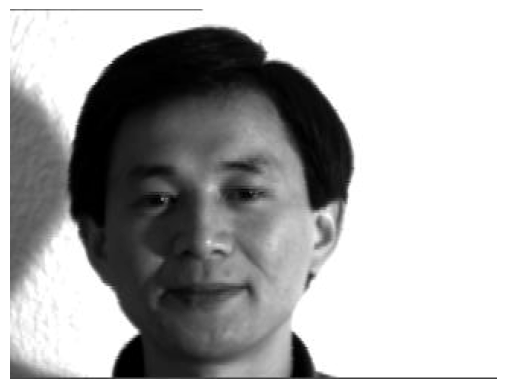

In [27]:
import os 
query_path = "data_new/subject06.rightlight_frame_1.jpg"
query_image = load_image(query_path)
print('Query image:')

image_idx = -1
directory = "data_new"
# Iterate through the images in the directory
for idx, filename in enumerate(os.listdir(directory)):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        current_image = load_image(filepath)
        # Compare with the query image
        if np.array_equal(query_image, current_image):
            image_idx = idx
            break
        
print(image_idx)

preview_image(query_image)

In [11]:
# extract all file paths ending with jpg
import os
import glob
gallery_images = []
for file in glob.glob("data_new/*.jpg"):
    gallery_images.append(load_image(file))

# preview the first 3 gallery images
print(f"Loaded {len(gallery_images)} gallery images.")
# print('Gallery images:')
# for i in range(3):
#     preview_image(gallery_images[i])

Loaded 179 gallery images.


In [22]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def estimate_joint_probability_persons(
    training_data, filter_function, similarity_function, alpha_grid_size, mu_grid_size, n_iter=500
):
    """
    Corrected implementation of joint probability density estimation.
    """
    alpha_grid = np.linspace(0, 1, alpha_grid_size)
    mu_grid = np.linspace(0, 1, mu_grid_size)
    density = np.zeros((alpha_grid_size, mu_grid_size))

    for _ in range(n_iter):
        # Step 2: Randomly select a query image
        query_idx = np.random.choice(len(training_data))
        query_image = training_data[query_idx]["image_data"]
        query_id = training_data[query_idx]["subject_id"]
        query_illumination = training_data[query_idx]["illumination"]

        # Compute similarities
        similarities_same_person = []
        similarities_other_persons = []

        for gallery_data in training_data:
            gallery_image = gallery_data["image_data"]
            gallery_id = gallery_data["subject_id"]
            gallery_illumination = gallery_data["illumination"]

            sim_raw = similarity_function(query_image, gallery_image)
            sim_filtered = similarity_function(
                filter_function(query_image), filter_function(gallery_image)
            )

            if gallery_id == query_id and gallery_illumination != query_illumination:
                similarities_same_person.append((sim_raw, sim_filtered))
            elif gallery_id != query_id:
                similarities_other_persons.append((sim_raw, sim_filtered))

        # Step 3: Compute confusion margin (μ)
        if len(similarities_same_person) >= 2:
            top_1_sim = max(sim[0] for sim in similarities_same_person)
            top_2_sim = max(sim[0] for sim in similarities_same_person if sim[0] != top_1_sim)
            mu = top_1_sim - top_2_sim
        else:
            mu = 0
        mu_idx = np.argmin(np.abs(mu_grid - mu))

        # Step 4: Iterate over α grid
        for alpha_idx, alpha in enumerate(alpha_grid):
            # Compute combined similarity scores for query
            similarity_query = [
                alpha * sim[0] + (1 - alpha) * sim[1] for sim in similarities_same_person
            ]
            similarity_other = [
                alpha * sim[0] + (1 - alpha) * sim[1] for sim in similarities_other_persons
            ]

            # Compute numerator and denominator for δ(kΔα)
            numerator = max(similarity_query) if similarity_query else 0
            denominator = max(similarity_other) if similarity_other else 1  # Avoid division by zero

            delta = numerator / denominator if denominator != 0 else 0

            # Update density
            density[alpha_idx, mu_idx] += delta

    # Step 7: Apply Gaussian smoothing
    smoothing_sigma = 0.05 * max(alpha_grid_size, mu_grid_size)
    density = gaussian_filter(density, sigma=smoothing_sigma)

    # Step 8: Normalize density to unit integral
    density /= np.sum(density)

    plot_density(alpha_grid, mu_grid, density, n_iter)
    return alpha_grid, mu_grid, density


def plot_density(alpha_grid, mu_grid, density, epoch):
    """
    Plot the density as a 3D surface.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(mu_grid, alpha_grid)
    
    ax.plot_surface(X, Y, density, cmap='viridis', edgecolor='none')
    ax.set_title(f"Density Estimate after {epoch} Epochs")
    ax.set_xlabel("μ")
    ax.set_ylabel("α")
    ax.set_zlabel("Density")
    plt.show()


Loaded 43 entries into the dataset.
Subject ID: 8
Illumination :c


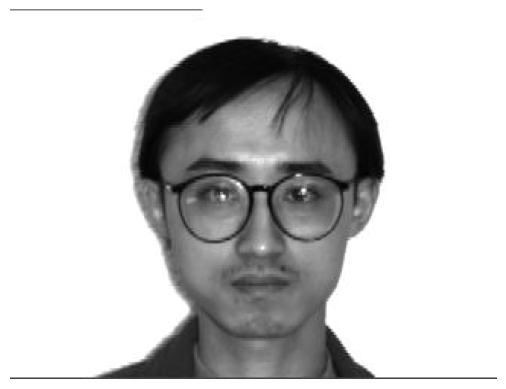

Subject ID: 11
Illumination :c


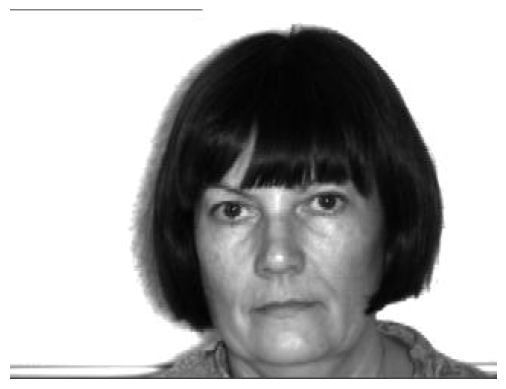

Subject ID: 10
Illumination :c


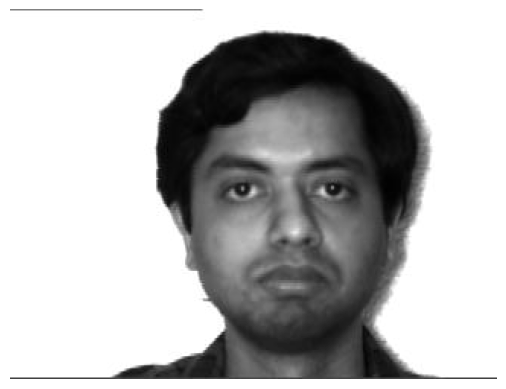

In [13]:
import os
import glob

# Function to extract subject ID from filename
def extract_subject_id(filename):
    basename = os.path.basename(filename)  # Get file name without directory
    return int(basename.split('_')[0].split('.')[0].replace("subject","")) if basename.find("_") else int(basename.split('.')[0].replace("subject","")) # Assuming the subject ID is before the first underscore

def extract_subject_lighting(filename):
    basename = os.path.basename(filename)
    if "centerlight" in filename:
        return "c"
    if "leftlight" in filename:
        return "l"
    if "rightlight" in filename:
        return "r"
    else:
        return "n"

# Initialize the dataset
dataset = []

# Iterate through the jpg files
for file in glob.glob("data_center/*.jpg"):
    basename = os.path.basename(file)
    
    # if basename in query_path:
    #     continue
    
    subject_id = extract_subject_id(file)
    lighting = extract_subject_lighting(file)
    image_data = load_image(file)  # Assuming load_image is defined elsewhere
    dataset.append({"subject_id": subject_id, "image_data": image_data,"illumination":lighting,"query_name":basename})

# Preview the first 3 entries in the dataset
print(f"Loaded {len(dataset)} entries into the dataset.")
for i in range(min(3, len(dataset))):
    print(f"Subject ID: {dataset[i]['subject_id']}")
    print(f"Illumination :{dataset[i]['illumination']}")
    preview_image(dataset[i]['image_data'])  # Assuming preview_image is defined elsewhere


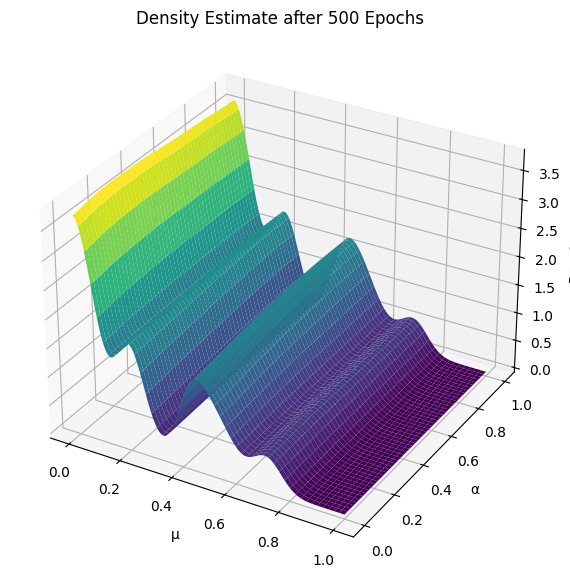

In [23]:
# Example usage with dummy data (to be replaced with actual images)
# query_image = np.random.rand(50, 50)  # Replace with actual image
# gallery_images = [np.random.rand(50, 50) for _ in range(10)]  # Replace with gallery images

ITERATIONS = 500

alpha_grid,mu_grid, density = estimate_joint_probability_persons(dataset,self_quotient_image, cosine_similarity, alpha_grid_size=1000,mu_grid_size=1000, n_iter=ITERATIONS)



In [48]:
def visualize_similarities(query_image, dataset, filter_function, similarity_function, alpha_grid, mu_grid, density, idx, top_n=25):
    """
    Visualize the query image with top matching images, showing their similarity scores.
    
    Parameters:
    -----------
    query_image : array-like
        The query image to compare against all others.
    dataset : list of dicts
        List of images with metadata.
    filter_function : callable
        Image filtering/preprocessing function.
    similarity_function : callable
        Function to compute similarity between images.
    alpha_grid : array
        Grid of alpha values from joint probability estimation.
    mu_grid : array
        Grid of mu values from joint probability estimation.
    density : 2D array
        Joint probability density matrix.
    idx : int
        Index of the query image in the dataset.
    top_n : int, optional
        Number of top similar images to display (default: 25).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    # Compute unprocessed similarities for all images
    sims1 = []
    for gallery_idx, gallery_image_val in enumerate(dataset):
        if gallery_idx == idx:  # Skip the query image itself
            continue
        
        gallery_image = gallery_image_val["image_data"]
        sim1 = similarity_function(query_image, gallery_image)
        sims1.append((gallery_idx, sim1, gallery_image_val))
    
    # Sort by unprocessed similarity
    sims1.sort(key=lambda x: x[1], reverse=True)
    
    # Compute maximum possible difference for normalization
    if len(sims1) > 1:
        max_sim1 = sims1[0][1]
        min_sim1 = sims1[-1][1]
        max_mu = max_sim1 - min_sim1
        
        # Compute normalized mu as the difference between the top two unprocessed similarities
        mu = abs(sims1[0][1] - sims1[1][1]) 
    else:
        mu = 0  # If there is only one match, set mu to 0
    print(mu)
    # Process top matches and compute combined similarity
    similarities = []
    for gallery_idx, sim1, gallery_image_val in sims1:
        gallery_image = gallery_image_val["image_data"]

        # Compute filtered similarity
        filtered_sim = similarity_function(
            filter_function(query_image), 
            filter_function(gallery_image)
        )
        
        # Determine optimal alpha based on density and normalized mu
        mu_idx = np.argmin(np.abs(mu_grid - mu))
        alpha_probabilities = density[:, mu_idx]
        # print(alpha_probabilities)
        best_alpha_idx = np.argmax(alpha_probabilities)
        best_alpha = alpha_grid[best_alpha_idx]
        
        sims2 = best_alpha * sim1 + (1 - best_alpha) * filtered_sim
        
        if gallery_image_val['subject_id'] == 6 and gallery_image_val['illumination']=='c':
            similarities.append({
                'image': gallery_image,
                'subject_id': gallery_image_val['subject_id'],
                'illumination': gallery_image_val['illumination'],
                'query_name': gallery_image_val['query_name'],
                'sim2': sims2,
                'sim1': sim1
            })
    
    # Sort similarities by combined similarity
    similarities.sort(key=lambda x: x['sim2'], reverse=True)
    
    # Select top N images
    top_similarities = similarities[:top_n]
    
    # Determine grid layout
    n_cols = 5
    n_rows = min(math.ceil((top_n + 1) / n_cols), 6)  # Limit to 6 rows
    
    # Create figure with adjusted size
    plt.figure(figsize=(15, 3 * n_rows))
    
    # Plot query image first
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(query_image, cmap='gray')
    plt.title('Query Image')
    plt.axis('off')
    
    # Plot top matching images
    for plot_idx, sim_data in enumerate(top_similarities, start=2):
        if plot_idx > n_rows * n_cols:
            break  # Stop if we exceed subplot capacity
        
        plt.subplot(n_rows, n_cols, plot_idx)
        plt.imshow(sim_data['image'], cmap='gray')
        plt.title(f"S{sim_data['subject_id']} {sim_data['illumination']}\n"
                  f"Unprocessed: {sim_data['sim2']:.3f}\n"
                  f"Combined: {sim_data['sim1']:.3f}", fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [16]:
best_match, similarity_score,alpha,unmatched = match_faces(query_image,dataset,self_quotient_image,
                                                           mutual_subspace_method,alpha_grid,mu_grid,density,image_idx)
match_image = best_match["image_data"]
similarity_score_2 = mutual_subspace_method(match_image,query_image)
print(f"{similarity_score},{similarity_score_2}")


0.755209001091815,0.7074802548386218


0.21228686189171841


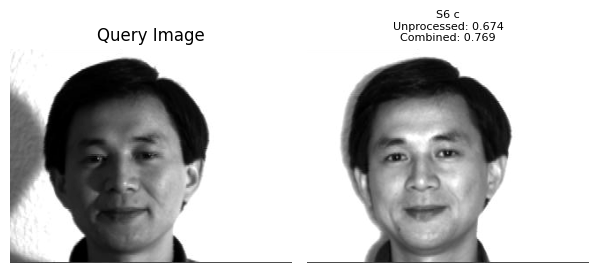

In [49]:
visualize_similarities(query_image, dataset, self_quotient_image, cosine_similarity, alpha_grid, mu_grid, density, image_idx)